# Manisha Pednekar NLP Homework 7

In [1]:
import pandas as pd
import numpy as np

import re
import nltk

from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os  # for os.path.basename
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE

import matplotlib as mpl

from sklearn.manifold import MDS

from matplotlib.font_manager import FontProperties
    

<font color=red> Cluster the reviews that you collected in homework 5, by doing the following: 
 <br>
1.	In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana. </font><br>  

I collected movie reviews on four different movies with 25 reviews per movie of genre "Animation", thus 100 reviews total. The movies I chose to create this movie review dataset are Cars 3, Toy Story 4, The Grinch and Aladdin. I created a .csv file named “MovieDf” with the following 6 columns after web scraping the permalinks for movie reviews: Movie Name, Permalink URL, review title, review text, user rating and Label (positive/ negative) based on user rating. Here I am loading this .csv file for the movie reviews clustering assignment.

I did not follow Sarkar books code for this clustering assignment. I was curious to know how the code works; especially the TF-IDF vectorizer and K-means algorithm tf-idf matrix thus I tried several code snippets from the web. But I used most of the python code from this website: http://brandonrose.org/clustering

I started with normalizing the text formed by review title and review text. I used Snowball stemmer to normalize the words to its root, removed the stop words. The I converted the review texts into a tf-idf matrix, then apply the term frequency-inverse document frequency weighting to generate a measure of similarity between each text and the other texts in the dataset and subtracting it from 1 provides cosine distance. Using the tf-idf matrix, I ran k-means clustering algorithms to better understand the hidden structure within the reviews. The cluster plot shows the distribution of the movies within each cluster. The plot also shows the list of top 8 words identified that are nearest to the cluster centroid for each cluster. The cluster plot was generated by converting the cosine similarity distance matrix using tf-idf matrix into a 2-dimensional array using multidimensional scaling. <br>

<font color=red> 2.	Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact. </font>

We cycle through the clusters and print out top keywords based on their tf-idf scores to characterize what each cluster is generally centered on semantically. We can see the word trends for each distint cluster resulted by k-means. The top words somewhat identifies the movies in that particular cluster for this particular dataset. I choose k as 2, 4 and 6. 

a) For **K = 2** Top terms per cluster:

Cluster 0 words: toy, toy, story, disappointed, franchise, film, ending, good,

**Cluster 0 films: Cars 3, Toy Story 4**

Cluster 1 words: movie, grinch, disney, one, great, film, liked, aladdin,

**Cluster 1 films: Aladdin and The Grinch**

b) For **K = 4** Top terms per cluster:

Cluster 0 words: disappointed, sequel, never, need, seems, fan, reviews

Cluster 0 films: Cars 3

Cluster 1 words: disney, aladdin, film, williams, great, robin, robin, movie,

Cluster 1 films: Aladdin

Cluster 2 words: toy, toy, story, character, film, movie, emotional, franchise

Cluster 2 films: Toy Story 4

Cluster 3 words: movie, grinch, good, one, liked, loved, reviews, better,

Cluster 3 films: The Grinch, Cars 3

c) For **K = 6** Top terms per cluster: 

Cluster 0 words: toy, toy, story, movie, film, woody, franchise, emotional,

Cluster 0 titles: Toy Story 4

Cluster 1 words: great, disney, movie, one, character, song, williams, very,

Cluster 1 titles: Aladdin

Cluster 2 words: movie, one, loved, liked, watch, time, funny, good,

Cluster 2 titles: Cars 3,Toy Story 4, The Grinch, Aladdin

Cluster 3 words: grinch, movie, even, liked, one, does, making, original,

Cluster 3 titles: The Grinch

Cluster 4 words: aladdin, film, williams, robin, disney, robin, genie, best,

Cluster 4 titles: Aladdin

Cluster 5 words: disappointed, reviews, good, better, film, great, sequel, ending,

Cluster 5 titles: Cars 3, Toy Story 4,The Grinch, Aladdin

<font color=red> 3.	Explain which of the two clustering results from question 1 is preferable (if one of them is), and why.</font> <br>

The cluster top words and plots do give us a quick understanding of our movie review dataset but it is not relatively easy to pick out the clustering results for the 3 different k-values. I prefer the results of K= 2 clustering method since the 2 clusters are easily distinguishable from the cluster plot. It has simple, intuitive labels generated for each cluster.
<br>
Since our movie dataset is quite small, we did not get distinct blobs for clustering results via k-means. as known for k-means algorithm, it gives different results verytime I ran it for a specific k value. It converges run to run vary vastly depending on the random initialization, thus the performance of k-means depends on the initialization of the cluster centers


In [5]:
stemmer = SnowballStemmer("english")

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


In [6]:
df = pd.read_csv("MovieDf.csv")

### I used groupby method on reviews dataset to obtain summary statistics on the user rating for each movie. It shows that Toy Story 4 has the highest rating, followed by Aladdin, The Grinch and then Cars 3.

In [22]:
df.groupby('MovieName').mean()[['rRating']]

,rRating
MovieName,
Aladdin,8.857143
Cars 3,2.440000
The Grinch,6.800000
Toy Story 4,9.958333


In [8]:
df["rText"].fillna(" ", inplace = True) 
df['fullText'] = df["rTitle"].map(str)+ '. ' + df["rText"]
fText = []
fText = df["fullText"].values.tolist()
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in fText:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('There are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
# =============================================================================

There are 15479 items in vocab_frame


In [9]:
vocab_frame.head()

,words
ignor,ignore
all,all
the,the
bad,bad
review,reviews


In [58]:
####--------------------Tf-idf and document similarity-----------------------####

stopWords = nltk.corpus.stopwords.words('english')
moreList = ["'s", "n't"] 
stopWords.extend(moreList) 
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=100000,
                                 min_df=0.1, stop_words=stopWords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(fText) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

(100, 107)


In [59]:
#----terms is just a list of the features used in the tf-idf matrix. This is a vocabulary
terms = tfidf_vectorizer.get_feature_names()

In [60]:
#---------------------------------------------------------------*************
######## For multidimensional scaling later
#---------------------------------------------------------------*************
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [61]:
df2 = df.copy()

In [84]:
#---------------------------------------------------------------*************
####     K-means clustering
#---------------------------------------------------------------*************
# define markers for clusters    
markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#ffe119', 5: '#000000'}
#set up cluster name string
wordStr = ""
#set up cluster names using a dict
ret = dict()

def movieKmeanClusters(num_clusters):
    km = KMeans(n_clusters=num_clusters)

    km.fit(tfidf_matrix)
    
    clusters = km.labels_.tolist()
    
    df2['cluster'] = clusters
    #df2 = df.copy()
    df2.set_index("cluster", inplace = True)
    
    #df2['cluster'].value_counts()
    print("Top terms per cluster:")
    #print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    
    for i in range(num_clusters):
        print("\n\nCluster %d words:" % i, end='')
        wordStr = ""
        for ind in order_centroids[i, :8]: #replace 6 with n words per cluster
            print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
            wordStr = wordStr + str(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0]) + " "
        print() #add whitespace
        print() #add whitespace
        #slice.update({character:len(character)})
        ret.update({i: wordStr})
        print("Cluster %d titles:" % i, end='')
        for title in df2.loc[i]['MovieName'].values.tolist():
            print(' %s,' % title, end='')
    # dimensionality reduction using MDS       
    MDS()
    
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    ###############################################
    #---------------------------------------------------------------*************
    ###Visualizing document clusters
    #---------------------------------------------------------------*************
   
    titlesPlt = df2['MovieName'].values.tolist()
    #create data frame that has the result of the MDS plus the cluster numbers and titles
    dfPlt = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titlesPlt)) 
    
    #group by cluster
    groups = dfPlt.groupby('label')
    
    
    # set up plot
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    
    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        marker = markers[name] 
        ax.plot(group.x, group.y, marker=marker, linestyle='', ms=12, 
                label=ret[name], color=cluster_colors[name], 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='False',      # ticks along the bottom edge are off
            top='False',         # ticks along the top edge are off
            labelbottom='False')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='False',      # ticks along the bottom edge are off
            top='False',         # ticks along the top edge are off
            labelleft='False')
        
    fontP = FontProperties()
    fontP.set_size('small')       
    #ax.legend(numpoints=1)  #show legend with only 1 point
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, shadow=True, ncol=5, numpoints=1, prop=fontP)
    
    #add label in x,y position with the label as the film title
    for i in range(len(dfPlt)):
        ax.text(dfPlt.loc[i]['x'], dfPlt.loc[i]['y'], dfPlt.loc[i]['title'], size=8)  

   
    plt.show()


Top terms per cluster:


Cluster 0 words: disappointed, sequel, never, need, seems, 'm, fan, reviews,

Cluster 0 titles: Cars 3, Cars 3, Cars 3, Cars 3, Toy Story 4, Toy Story 4, The Grinch,

Cluster 1 words: disney, aladdin, film, williams, great, robin, robin, movie,

Cluster 1 titles: Toy Story 4, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin,

Cluster 2 words: toy, toy, story, character, film, movie, emotional, franchise,

Cluster 2 titles: Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4,

Cluster 3 words: movie, grinch, good, one, liked, loved, reviews, better,

Cluster 3 titles: Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


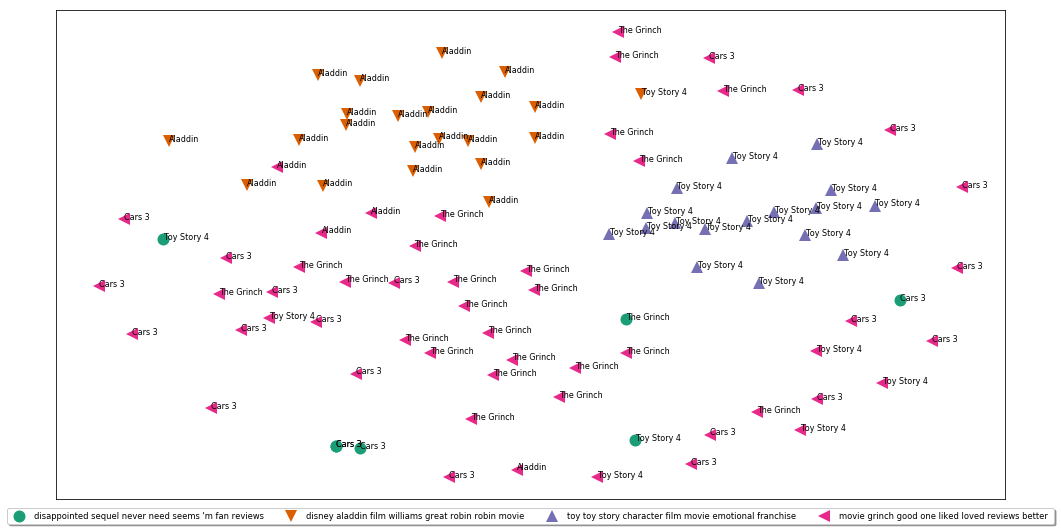

In [87]:
num_clusters = 4
movieKmeanClusters(num_clusters)

Top terms per cluster:


Cluster 0 words: toy, toy, story, disappointed, franchise, film, ending, good,

Cluster 0 titles: Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, The Grinch, The Grinch, The Grinch, Aladdin,

Cluster 1 words: movie, grinch, disney, one, great, film, liked, aladdin,

Cluster 1 titles: Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Toy Story 4, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinc

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


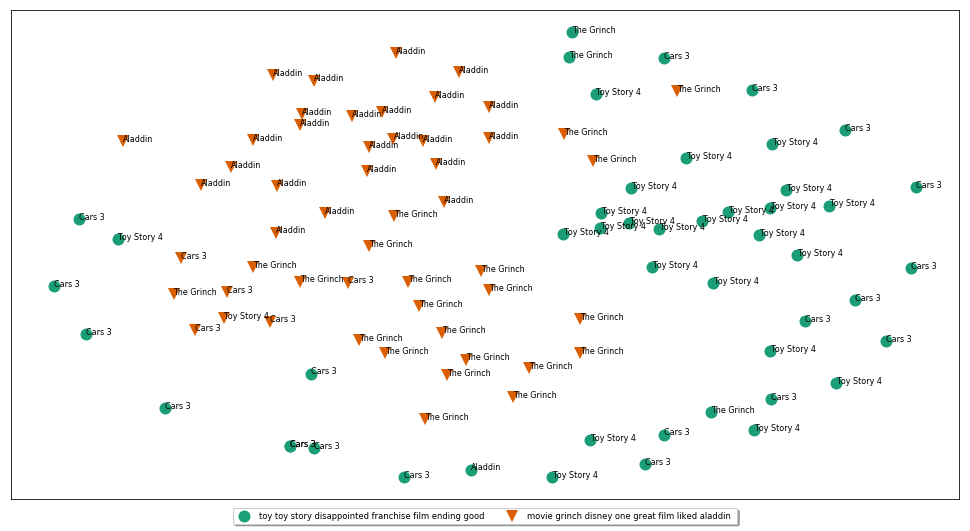

In [82]:
num_clusters = 2
movieKmeanClusters(num_clusters)

Top terms per cluster:


Cluster 0 words: toy, toy, story, movie, film, woody, franchise, emotional,

Cluster 0 titles: Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4, Toy Story 4,

Cluster 1 words: great, disney, movie, one, character, song, williams, very,

Cluster 1 titles: Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin, Aladdin,

Cluster 2 words: movie, one, loved, liked, watch, time, funny, good,

Cluster 2 titles: Cars 3, Cars 3, Cars 3, Cars 3, Cars 3, Toy Story 4, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, Aladdin, Aladdin,

Cluster 3 words: grinch, movie, even, liked, one, does, making, original,

Cluster 3 titles: The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch, The Grinch,

Cluster 4 words: aladdin, film, williams, robin, disn

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


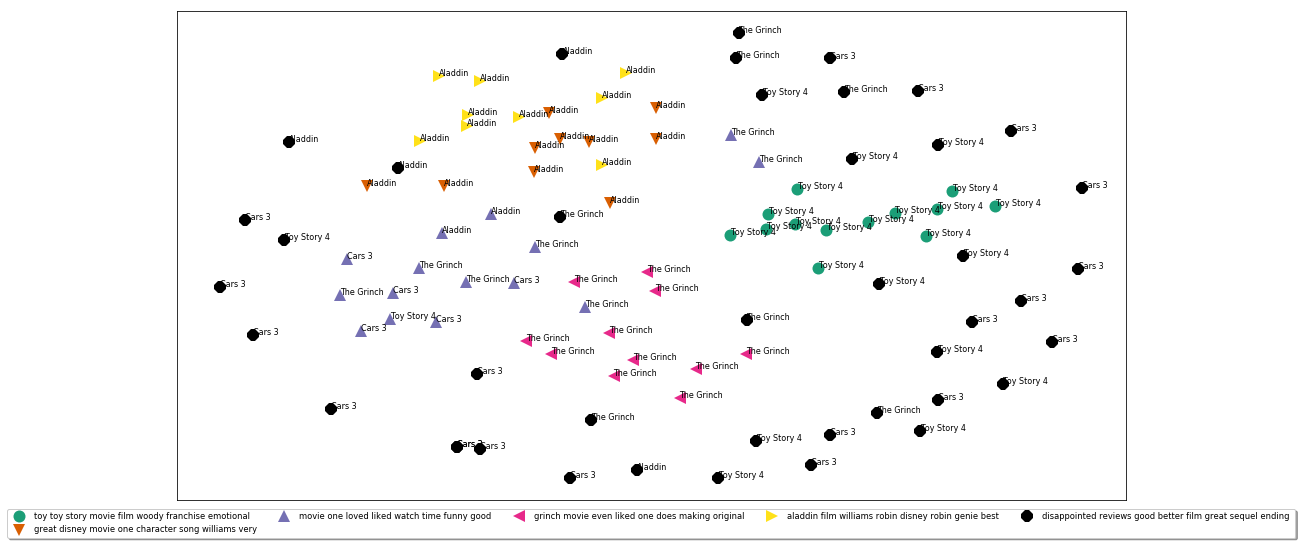

In [85]:
num_clusters = 6
movieKmeanClusters(num_clusters)